Team Members: Amira Johnson (amiraj), Segi Odongo (sodongo), Karolena Zhou (kxzhou)

Lyric generation
- Create new song based on artist

Two methods
- Word2Vec
- Transformers

# Harmony in Code: Exploring Lyric Generation with Generative Models
**Objective**
* Objective Question: How do the differences between Word2Vec and Transformer Model Architectures contribute to each approach's ability to produce cohesive song lyrics?

* Our project goal is to utilize generative models – Word2Vec, Transformer Models – to generate song lyrics in the style of the input artist. We aim to address the challenges of using machine learning to produce lyrics that mimic the style of human songwriters. The dataset we use consists of song lyrics spanning a variety of artists and genres. Into the model goes the raw song lyrics, and as a result, the model produces generated lyrics that mimic the style of the input artist.





ADD MORE SONGS AND ARTISTS TO THE DATASET HERE: https://docs.google.com/spreadsheets/d/1jur1q5c-1NimDDYJ3pDL-P0Is4z9JKpjceEWYx9gFl0/edit?usp=sharing


Task Input and Output

Input: Dataset containing song artist, album, and lyrics. Terms like [Verse], [Chorus], etc. have been omitted from the lyrics.
Output: Generated song lyrics in the style of the artist.

Training Data

* The training data consists of shuffled song lyrics.
* Source - a mixture of datasets from Kaggle, and manually added songs.

Intended Use
* To generate new song lyrics that mimic the style of the artist.
  
Risks:
*   Inappropriate Content: The model can produce songs with explicit language or content.
*   Copyright: Generated lyrics could unintentionally too closely resemble an existing song.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pprint import pprint
import random

In [ ]:
url = 'https://raw.githubusercontent.com/amirajohnson/10315-FinalProjectS24/main/300%20Song%20Lyric%20Dataset%20-%20Sheet1%20(1).csv'
df = pd.read_csv(url)
#df = df.drop('Unnamed: 4', axis = 1)
df

,Artist,Album,Song Name,Lyrics with Characters,Lyrics
0,Drake,Certified Lover Boy,Certified Lover Boy,\nPut my feelings on ice\nAlways been a gem\nC...,\nPut my feelings on ice\nAlways been a gem\nC...
1,Drake,Certified Lover Boy,Like I’m Supposed To/Do Things,\nHands are tied\nSomeones in my ear from the ...,\nHands are tied\nSomeones in my ear from the ...
2,Drake,Certified Lover Boy,Not Around,"\nYeah, we back\nWassup ladies?\nSwishahouse, ...","\nYeah, we back\nWassup ladies?\nSwishahouse, ..."
3,Drake,Certified Lover Boy,In the Cut (Ft. Roddy Ricch),"Ayy, yeah\nPipe this shit up and I turn this s...","Ayy, yeah\nPipe this shit up and I turn this s..."
4,Drake,Certified Lover Boy,Zodiac Sign (Ft. Jessie Reyez),\nYou ask how many girls I been with in my lif...,\nYou ask how many girls I been with in my lif...
...,...,...,...,...,...
294,Rihanna,Diamonds,Unapologetic,\nShine bright like a diamond\nShine bright li...,\nShine bright like a diamond\nShine bright li...
295,Rihanna,Desperado,Anti,\nDesperado\nSittin in an old Monte Carlo\nA m...,\nDesperado\nSittin in an old Monte Carlo\nA m...
296,Rihanna,Whats My Name,Loud,"[Refrain: Rihanna & Drake]\nOh na-na, whats my...","\nOh na-na, whats my name?\nOh na-na, whats my..."
297,Rihanna,Loveeeeee Song,Unapologetic,[Intro: Future]\nAint nothin wrong with it...\...,\nAint nothin wrong with it...\n\n\nI dont wan...


## Method #1: Word2Vec Model - follows tutorial from Recitation 9
*   This model takes in a corpus of song lyrics and learns to represent them such that words used in similar contexts are closer together in a vector space. Our goal is for the produced embeddings to capture relationships between words in the song lyrics, and from those, be able to generate new lyrics that mimic the style of the input artist.



## Training Flag

In [ ]:
#training flag
train = False
#train = True

In [ ]:
#gets rid of all the characters in characters list from the text
def get_lyrics(text):
  characters = ["?", ".", "!", "(", ")", "&", ':', ";", ",", "'", "!"]
  for i in characters:
    text = text.replace(i, "")
  lyrics = text.split("\n")
  word = []
  for i in lyrics:
    for j in i.split(" "):
      if j != "":
        word.append(j)
  return word

def remove_nonalphanum(text):
  characters = set(["?", ".", "!", "(", ")", "&", ':', ";", ",", "'", "!" '\n'])
  no_newlines = text.split('\n')
  res = []
  for sentence in no_newlines:
    words = sentence.split(' ')
    for word in words:
      final_word = ''
      for char in word:
        if char.isupper():
          res.append(final_word)
          final_word = char
        elif char not in characters:
          final_word += char
      res.append(final_word)
  return res

#given an artists' songs, and their lyrics, create a vocabulary list.
def get_vocab(songs_and_lyrics):
  vocab = []
  for song in songs_and_lyrics:
    for word in songs_and_lyrics[song]:
      vocab.append(word)
  return vocab

#generate a one_hot vector -- 0 if the words are not (i, i+1) neighbors, i otherwise
def one_hot(index, vocab_size):
  res = [0]*vocab_size
  res[index] = 1
  return res

#we need to map the vocab to a particular index and the index back to the word
def mapping(vocab):
  word_to_index = dict()
  index_to_word = dict()

  # word_to_index['<pad>'] = 0
  # index_to_word[0] = '<pad>'
  index = 0
  for word in set(vocab):
    if word not in word_to_index:
      word_to_index[word] = index
      index_to_word[index] = word
      index+=1
  return word_to_index, index_to_word

def get_training_data(vocab):
  pairs = []
  one_hots = []
  for i in range(2, len(vocab)-2):
    pairs.append([vocab[i], vocab[i-1]])
    pairs.append([vocab[i], vocab[i-2]])
    pairs.append([vocab[i], vocab[i+1]]) #correct word
    pairs.append([vocab[i], vocab[i+2]])
    one_hots.append(one_hot(i, len(vocab)))
  return np.array(pairs), np.array(one_hots)

In [ ]:
def get_targets(word, vocab_list):
  #wanna try to get two negative samples between each.
  word_index = vocab_list.index(word)
  matches = []
  non_matches = []
  if word_index != len(vocab_list) - 1:
    for current in vocab_list:
      if current == vocab_list[word_index + 1]: #if its a pair
        if current not in matches:
          matches.append(current)
      else:
          non_matches.append(current)

  if(len(matches) > 1): print("HEREEEE!!!", word, True)

  #now that we have all the matches and non matches, we can load them into a dictionary with two in between each until the matches are all gone
  targets = []
  while len(matches) > 0:
      if len(non_matches) >= 2: #make sure we don't go out of bounds
        match_word = matches[0]

        targets.append((word, match_word, 1))

        matches.pop(0)
      else:
        break
  return targets

In [ ]:
artists = df['Artist']
# artist = input("Choose an artist to generate a song for: ").title()
artist = "Bruno Mars"
songs_and_lyrics = dict()
songlyrics = []
for i in range(len(artists)):
  if artist in artists[i]:
    song = df['Song Name'][i]
    #tokenize the text
    lyrics1 = df['Lyrics'][i]
    songlyrics += get_lyrics(lyrics1)
    lyrics = df['Lyrics'][i]
    lyrics = remove_nonalphanum(lyrics)
    songs_and_lyrics[song] = lyrics
#get the vocabulary
vocab = get_vocab(songs_and_lyrics)
print(songlyrics)

while("" in vocab):
    vocab.remove("")

training_data, y_true = get_training_data(vocab)

['Whoo', 'James', 'Remix', 'Im', 'an', 'A', 'town', 'playa', 'turned', 'uptown', 'pimp', 'This', 'shit', 'is', 'whipped', 'Eddie', 'Murphy', 'red', 'leather', 'the', 'pants', 'on', 'Hammer', 'Im', 'too', 'legit', 'Oh', 'my', 'hair', 'so', 'gorgeous', 'make', 'them', 'girls', 'so', 'sick', 'I', 'wait', 'in', 'line', 'bitches', 'even', 'Beyonce', 'want', 'this', 'shit', 'Im', 'too', 'hot', 'hot', 'damn', 'I', 'like', 'myself', 'on', 'Instagram', 'Im', 'too', 'hot', 'hot', 'damn', 'Im', 'Jérôme', 'Rome', 'with', 'a', 'Gina', 'and', 'Pam', 'Im', 'too', 'hot', 'hot', 'damn', 'Covered', 'in', 'gold', 'you', 'know', 'who', 'I', 'am', 'Im', 'too', 'hot', 'hot', 'damn', 'Thank', 'Def', 'Jam', 'for', 'that', 'money', 'Cash', 'Money', 'Got', 'a', 'brand-new', 'cape', 'hallelujah', 'Got', 'a', 'brand-new', 'cane', 'hallelujah', 'Got', 'a', 'brand-new', 'chain', 'hallelujah', 'You', 'better', 'know', 'T', 'James', 'gon', 'get', 'to', 'ya', 'You', 'know', 'Uptown', 'Funk', 'gon', 'get', 'to', 'ya', 

In [ ]:
#From Recitation 9

def visualize_embedded_tokens(vocab, vocab_vectors, prev_vocab_vectors=None, prev_token_index=None, next_token_index=None,
        next_token_probs=None, loss=None, fontsize=None, title=None, fig=None, update_inplace=False):
    min_alpha = 0.1
    default_alpha = 0.6

    if fontsize is None:
        fontsize = 14

    if title is None:
        title = 'Embedded words/tokens'

    if fig is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, aspect='equal')
    else:
        ax = fig.gca()
        ax.clear()

    # Add x and y axis lines
    # Z order in the back
    ax.axhline(0, color='black', lw=1, zorder=0)
    ax.axvline(0, color='black', lw=1, zorder=0)

    # For each token in the vocab
    for i in range(len(vocab)):
        vocab_vector = vocab_vectors[i]
        token = vocab[i]

        point_color = 'tab:purple'
        point_size = 20
        line_color = 'tab:purple'
        line_width = 1
        label = token
        line_zorder = 1
        point_zorder = 2

        if next_token_probs is not None:
            alpha = next_token_probs[i]/np.max(next_token_probs)
            alpha = alpha*(1-min_alpha) + min_alpha
            point_color = 'tab:purple'
            line_color = 'tab:purple'
        else:
            alpha = default_alpha

        if prev_vocab_vectors is None and prev_token_index is not None and prev_token_index == i:
            point_color = 'tab:blue'
            point_size = 40
            line_color = point_color
            line_width = 2
            alpha = 1.0
            label = f'Prev: {token}'
            line_zorder += 10
            point_zorder += 10

        if next_token_index is not None and next_token_index == i:
            point_color = 'tab:purple'
            point_size = 40
            line_color = point_color
            line_width = 2
            alpha = 1.0
            label = f'Next: {token}'
            line_zorder += 10
            point_zorder += 10

        # Vector line
        ax.plot([0, vocab_vector[0]], [0, vocab_vector[1]], line_color, lw=line_width, alpha=alpha,
                zorder=line_zorder)

        # Vector point
        ax.scatter(vocab_vector[0], vocab_vector[1], s=point_size, c=point_color,
                zorder=point_zorder, alpha=alpha)

        # Label vectors with token from vocab

        # Shift text away from point, increase font size, and color a transparent
        # version of the point color

        # Offset text in the same direction as the vector
        num_chars = len(label)
        offset_scale = 0.9
        horiz_scale = 1.0 + 0.25*num_chars
        offset_shift = np.array([-num_chars*0.25-.05, -0.375])
        # offset_shift = np.array([0, 0])
        xy_offset = offset_scale * vocab_vector/np.linalg.norm(vocab_vector)
        xy_offset[0] *= horiz_scale
        xy_offset += offset_shift

        ax.annotate(label, (vocab_vector[0], vocab_vector[1]),
                    xytext=xy_offset, textcoords='offset fontsize',
                    fontsize=fontsize, color=point_color, alpha=alpha,
                    zorder=point_zorder)

    if prev_vocab_vectors is not None and prev_token_index is not None:
        vocab_vector = prev_vocab_vectors[prev_token_index]
        token = vocab[prev_token_index]

        point_color = 'tab:blue'
        point_size = 40
        line_color = point_color
        line_width = 2
        alpha = 1.0
        label = f'Prev: {token}'
        line_zorder += 10
        point_zorder += 10

        # Vector line
        ax.plot([0, vocab_vector[0]], [0, vocab_vector[1]], line_color, lw=line_width, alpha=alpha,
                zorder=line_zorder)

        # Vector point
        ax.scatter(vocab_vector[0], vocab_vector[1], s=point_size, c=point_color,
                zorder=point_zorder, alpha=alpha)

        # Label vectors with token from vocab

        # Shift text away from point, increase font size, and color a transparent
        # version of the point color

        # Offset text in the same direction as the vector
        num_chars = len(label)
        offset_scale = 0.9
        horiz_scale = 1.0 + 0.25*num_chars
        offset_shift = np.array([-num_chars*0.25-.05, -0.375])
        # offset_shift = np.array([0, 0])
        xy_offset = offset_scale * vocab_vector/np.linalg.norm(vocab_vector)
        xy_offset[0] *= horiz_scale
        xy_offset += offset_shift

        ax.annotate(label, (vocab_vector[0], vocab_vector[1]),
                    xytext=xy_offset, textcoords='offset fontsize',
                    fontsize=fontsize, color=point_color, alpha=alpha,
                    zorder=point_zorder)

    max_vocab_vector_mag = np.max(np.linalg.norm(vocab_vectors, axis=1))
    max_vocab_vector_mag *= 1.1
    ax.set_xlim(-max_vocab_vector_mag, max_vocab_vector_mag)
    ax.set_ylim(-max_vocab_vector_mag, max_vocab_vector_mag)

    if loss is not None:
        # Source: https://www.tutorialspoint.com/how-to-put-text-at-the-corner-of-an-equal-aspect-figure-in-python-matplotlib
        ax.annotate(f'Loss: {loss:0.4f}', xy=(0.98, 0.98), xycoords='axes fraction', fontsize=fontsize,
                    horizontalalignment='right', verticalalignment='top', color='tab:red')

    ax.set_title(title)

    if update_inplace:
        # Update figure inplace
        # Source: https://stackoverflow.com/questions/63794302/plot-inside-a-loop-with-google-colabs
        display.display(plt.gcf())
        display.clear_output(wait=True)
        sleep(0.01)

    return fig

In [ ]:
embedded_size = 2
np.random.seed(20)
U = np.random.normal(size=(len(vocab), embedded_size))
V = np.random.normal(size=(len(vocab), embedded_size))

In [ ]:
#Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Softmax function
def softmax(x):
    numerator = np.exp(x - max(x))
    denominator = np.sum(numerator)
    return numerator / denominator

# Function to update embeddings using gradient descent
def update_embeddings(embedding_matrix, context_matrix, error, learning_rate):
    embedding_matrix -= learning_rate * error
    context_matrix -= learning_rate * error
    return embedding_matrix, context_matrix

#Similarity function
def similarity(x_index, U, V):
    u = U[x_index].reshape((-1, 1))
    sim = V @ u

    return sim

#Predict function
def predict(x_index, U, V):
    sim = similarity(x_index, U, V)
    return softmax(sim)

def dL_dV(y_pred, y_meas_index, x_index, U):
    y_meas_onehot = np.zeros(y_pred.shape)
    y_meas_onehot[y_meas_index] = 1

    return np.outer(y_pred - y_meas_onehot, U[x_index])

def dL_du(y_pred, y_meas_index, x_index, V):
    y_meas_onehot = np.zeros(y_pred.shape)
    y_meas_onehot[y_meas_index] = 1

    return V.T @ (y_pred - y_meas_onehot)

def train_word2vec(training_data, epochs, learning_rate, U, V):
  word_to_index, index_to_word = mapping(vocab)
  # Training loop
  for epoch in range(epochs):
      total_loss = 0
      shuffled_indices = list(range(len(songlyrics)-1))
      random.shuffle(shuffled_indices)

      for corpus_index in shuffled_indices:
        prev_word = songlyrics[corpus_index]
        next_word = songlyrics[corpus_index+1]

        #get their indices
        input_word_index = word_to_index[prev_word]
        match_word_index = word_to_index[next_word]

        match_pred = predict(input_word_index, U, V)

        #get loss
        match_loss = -np.log(match_pred[match_word_index])

        total_loss += match_loss

        #update the embedding matrix somehow
        du_match = dL_du(match_pred, match_word_index, input_word_index, V)
        dV_match = dL_dV(match_pred, match_word_index, input_word_index, U)

        update = du_match.flatten()
        update_u = learning_rate * update
        U[i] -= update_u
        update_v = learning_rate * dV_match
        V -= update_v

      # Print average loss for each epoch
      print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(training_data)}")
      np.save(f'U_{epoch+1}.npy', U)
      np.save(f'V_{epoch+1}.npy', V)

Initialize [Hyper]Parameters and do training

In [ ]:
# Hyperparameters
embedding_size = 2
epochs = 100
learning_rate = 0.01

# Initialize embedding matrices
vocab_size = len(vocab)
embedding_matrix = np.random.rand(vocab_size, embedding_size)
context_matrix = np.random.rand(vocab_size, embedding_size)
if train:
  #Train
  train_word2vec(training_data, epochs, learning_rate, U, V)

In [ ]:
import random
word_to_index, index_to_word = mapping(vocab)
# pprint(word_to_index)
# U = np.load('U_100.npy')
# V = np.load('V_100.npy')
if train:
  word = "uptown"
  if len(word.split(" ")) > 1:
    prev_word = word.split()[-1]
    prev_index = word_to_index[prev_word]
  else:
    prev_index = word_to_index[word]
  yhat = predict(prev_index, U, V).flatten()
  next_token = np.random.choice(vocab, p = yhat)
  word += f' {next_token}'

  for i in range(20):
    prev_word = word.split()[-1]
    prev_index = word_to_index[prev_word]
    yhat = predict(prev_index, U, V).flatten()
    next_token = np.random.choice(vocab, p = yhat)
    word += f' {next_token}'
  print(word)

54
1


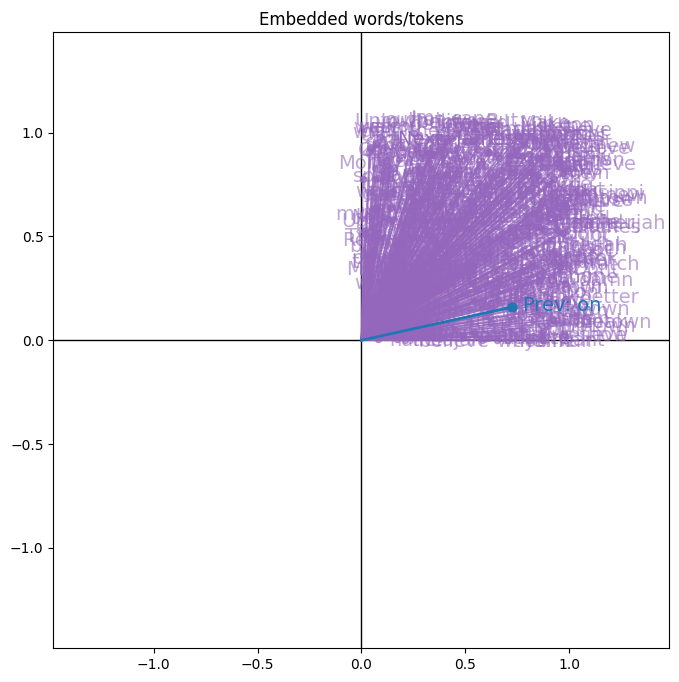

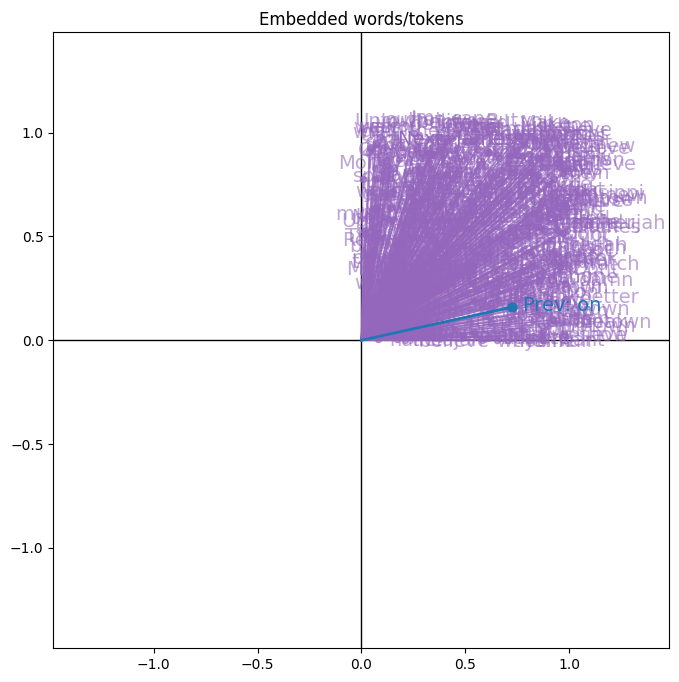

In [ ]:
#testing
#visualize the embeddings

prev_token = 'funk'

prev_index = word_to_index[prev_token]
y_hat = embedding_matrix[prev_index].flatten()

print(prev_index)
print(np.argmax(y_hat))
visualize_embedded_tokens(vocab, vocab_vectors = embedding_matrix, prev_vocab_vectors = context_matrix,
                          prev_token_index = prev_index, next_token_index = np.argmax(y_hat))

# (vocab, vocab_vectors, prev_vocab_vectors=None, prev_token_index=None, next_token_index=None,
#         next_token_probs=None, loss=None, fontsize=None, title=None, fig=None, update_inplace=False

## Method 2: Transformer Model

Can be found at this notebook link: https://colab.research.google.com/drive/1opgR2ilmv9SHX3oQcjzrcgGwCKiNDIp3?usp=sharing